05/17 Week13
1. 针对结果考虑多种情况的resolution和prior_sigma
2. q=r的情况单独分开
3. factor m的讨论单独进行

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn 
import math
import time
import random
np.random.seed(28)

#plotting setting
size=10;f=10
figsize=(8,6)

from ML_estimator import *
from Evaluation import *
from Basic import *
from EXP3_util import *

In [3]:
filepath='C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_13'

# EXP 3 synthetic priors (previous EXP4)

In [4]:
def experiment3(N,lmb,d,targets,phase_obs,ml_resol,prior_means,prior_sigma,flag_prior):
    # Array
    arr_dim=d*(N-1) # dimension of the array
    arr=array(N,arr_dim,0) # array elements location
    R_near=near_field_Boundary(lmb,arr_dim)
    arr_center=0.5*arr_dim
    time_ML=0
    time_ML_prior=0
    #Prepare arrays for results
    num_sam=5
    ML_targets=np.empty([len(targets),num_sam,2])
    ML_targets_prior=np.empty([len(targets),num_sam,2])

    #begin experiment
    if(flag_prior==False):
        for i in range (len(targets)):
            # if(i%50==0):
            #     print(i)
            
            for j in range(num_sam):
                #search space
                xrange=np.array([arr_center-R_near,arr_center+R_near])
                yrange=np.array([0,R_near])
                
                #ML
                T1=time.perf_counter()
                ml=ML()
                num_grid,Loc_MLgrid=ml.ML_grid(xrange,yrange,phase_obs[i,j],arr,lmb,resolution=ml_resol,flag_prior=False,flag_plot=False)
                num=num_grid[0]*num_grid[1]
                T2=time.perf_counter()
                time_ML+=(T2-T1)
                ML_targets[i,j]=Loc_MLgrid.reshape(2)        
        print(f'ML processing time per iteration:{time_ML/(len(targets)*num_sam)}s.')
        return ML_targets, num
    else:
        for i in range (len(targets)):
            # if(i%50==0):
            #     print(i)
            
            for j in range(num_sam):
                
                #search space
                prior_mean=prior_means[i,j]

                xrange_p=np.array([prior_mean[0]-3*prior_sigma,prior_mean[0]+3*prior_sigma])
                yrange_p=np.array([prior_mean[1]-3*prior_sigma,prior_mean[1]+3*prior_sigma])

                #ML + prior bounding search space
                T1=time.perf_counter()
                ml=ML()
                num_grid,Loc_MLgrid_prior=ml.ML_grid(xrange_p,yrange_p,phase_obs[i,j],arr,lmb,resolution=ml_resol,flag_prior=False,flag_plot=False)
                num_prior=num_grid[0]*num_grid[1]
                T2=time.perf_counter()
                time_ML_prior+=(T2-T1)
                ML_targets_prior[i,j]=Loc_MLgrid_prior.reshape(2)              
            
    
        print(f'ML + prior processing time per iteration:{time_ML_prior/(len(targets)*num_sam)}s.')
        return ML_targets_prior, num_prior


In [5]:
#main 
N=10 # number of elements
lmb=2e-3 # wavelength of the signal
d=0.25*lmb # distance between 2 adjacent elements


arr_dim=d*(N-1) # dimension of the array
arr=array(N,arr_dim,0) # array elements location
R_near=near_field_Boundary(lmb,arr_dim)
arr_center=0.5*arr_dim

# generating targets
N_target=100
# targets = sample_in_half_circle(R_near,N_target)+np.array([arr_center,0])
# # print(f"True target:{targets}")
# np.savetxt('targets.txt',targets)
targets=np.loadtxt('targets.txt')
targets=targets[0:50]



# EXP3

## phase noise and position noise converison

In [5]:
# noise_dB=np.array([0,10,20,30])
# phase_noise_dB= Position_dB_to_phase_dB(noise_dB,lmb)
# plt.figure()
# plt.plot(noise_dB,phase_noise_dB,'d--')
# plt.xlabel(r'Position noise $σ^{-2}$ [dB]')
# plt.ylabel(r'Phase noise $σ^{-2}$ [dB]')
# plt.grid()
# plt.savefig(filepath+'/Exp3_noise_conversion.eps',format='eps') 



## Exp3-1,3-2 fixed prior sigma or fixed grid size

In [6]:
#EXP3
noise_dB=np.array([0,10,20,30])
position_noise_std=Noise_dB_to_std(noise_dB)

prior_sigma=np.empty([5,len(position_noise_std)])
for i in range(len(position_noise_std)):
    prior_sigma[:,i]=lmb*np.array([0.0625,0.125,0.25,0.5,1])

ml_resol=lmb*np.array([0.0625,0.125,0.25,0.5,1])

ML_MSE_mean=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_mean_prior=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std_prior=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])


for i in range(len(position_noise_std)):
    #generate phase measurements
    # true_targets,phase_observations=EXP3_phase_generate(N,lmb,d,targets,noise_std[i],phi_0=1) #add noise to phase 
    true_targets,phase_observations=EXP3_position_noise_to_phase_generate(N,lmb,d,targets,position_noise_std[i],phi_0=1) #add noise to position, then generate noise-free phase 
    for k in range(len(prior_sigma)):
        # synthetic priors
        prior_means=Synthetic_prior(targets,5,prior_sigma[k,i])
        for j in range(len(ml_resol)):
            if(prior_sigma[k,0]<=4*ml_resol[j]):# Avoid too many grids (taking a long time)
                print(f'prior_sigma = {prior_sigma[k,i]/lmb} wavelength,',f'position_noise_std:{position_noise_std[i]}, ML1 resolution:{ml_resol[j]/lmb}wavelength')
                if(k==0): #just need execute once each prior_sigma
                    ML_targets,num=experiment3(N,lmb,d,targets,phase_observations,ml_resol[j],prior_means,prior_sigma[k,i],False)
                    ML_MSE_mean[i,0,j],ML_MSE_std[i,0,j]=evaluate(true_targets,ML_targets)
                    for m in range(1,len(prior_sigma)):
                        ML_MSE_mean[i,m,j]=ML_MSE_mean[i,0,j]
                        ML_MSE_std[i,m,j]=ML_MSE_std[i,0,j]
                    print(f'ML_mean_Squared_loss: {ML_MSE_mean[i,k,j]:.4},num:{num}')
                ML_targets_prior, num_prior=experiment3(N,lmb,d,targets,phase_observations,ml_resol[j],prior_means,prior_sigma[k,i],True)
                ML_MSE_mean_prior[i,k,j],ML_MSE_std_prior[i,k,j]=evaluate(true_targets,ML_targets_prior)
                print(f'ML_mean_Squared_loss_prior: {ML_MSE_mean_prior[i,k,j]:.4},num:{num_prior}')

prior_sigma = 0.0625 wavelength, position_noise_std:1.0, ML1 resolution:0.0625wavelength
ML processing time per iteration:1.447525058399886s.
ML_mean_Squared_loss: 3.838e-06,num:52975
ML + prior processing time per iteration:0.0013227299998980016s.
ML_mean_Squared_loss_prior: 1.283e-07,num:49
prior_sigma = 0.0625 wavelength, position_noise_std:1.0, ML1 resolution:0.125wavelength
ML processing time per iteration:0.36616767760075164s.
ML_mean_Squared_loss: 4.107e-06,num:13366
ML + prior processing time per iteration:0.00043455079954583196s.
ML_mean_Squared_loss_prior: 1.271e-07,num:16
prior_sigma = 0.0625 wavelength, position_noise_std:1.0, ML1 resolution:0.25wavelength
ML processing time per iteration:0.092102109998581s.
ML_mean_Squared_loss: 4.861e-06,num:3362
ML + prior processing time per iteration:0.00015222840115893633s.
ML_mean_Squared_loss_prior: 9.187e-08,num:4
prior_sigma = 0.0625 wavelength, position_noise_std:1.0, ML1 resolution:0.5wavelength
ML processing time per iteration:

In [7]:
position_noise_std=Noise_dB_to_std(noise_dB)
MSE_level_dB = np.negative(noise_dB)
print(MSE_level_dB)


ML_MSE_mean_scale=ML_MSE_mean/(lmb**2)  #scale according to wavelenth (not sure)
ML_MSE_mean_dB=todB(ML_MSE_mean_scale)
ML_MSE_std_scale=ML_MSE_std/(lmb**2)
ML_MSE_std_dB=todB(ML_MSE_mean_scale+ML_MSE_std_scale)-ML_MSE_mean_dB

ML_MSE_mean_prior_scale=ML_MSE_mean_prior/(lmb**2)  #scale according to wavelenth (not sure)
ML_MSE_mean_prior_dB=todB(ML_MSE_mean_prior_scale)
ML_MSE_std_prior_scale=ML_MSE_std_prior/(lmb**2)
ML_MSE_std_prior_dB=todB(ML_MSE_mean_prior_scale+ML_MSE_std_prior_scale)-ML_MSE_mean_prior_dB

[  0 -10 -20 -30]


d:\Jupyter\0_Spring_SP\Semester-project-2023\Evaluation.py:10: RuntimeWarning: divide by zero encountered in log
  return 10*np.log(x)/np.log(10)
C:\Users\73160\AppData\Local\Temp\ipykernel_11396\2744715738.py:14: RuntimeWarning: invalid value encountered in subtract
  ML_MSE_std_prior_dB=todB(ML_MSE_mean_prior_scale+ML_MSE_std_prior_scale)-ML_MSE_mean_prior_dB


In [8]:

with open(filepath+'/ML_MSE_mean_dB.txt', 'w') as outfile:
        for slice_2d in ML_MSE_mean_dB:
                np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol


with open(filepath+'/ML_MSE_std_dB.txt', 'w') as outfile:
        for slice_2d in ML_MSE_std_dB:
                np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol

with open(filepath+'/ML_MSE_mean_prior_dB.txt', 'w') as outfile:
        for slice_2d in ML_MSE_mean_prior_dB:
                np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol


with open(filepath+'/ML_MSE_std_prior_dB.txt', 'w') as outfile:
        for slice_2d in ML_MSE_std_prior_dB:
                np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol





In [5]:
noise_dB=np.array([0,10,20,30])
position_noise_std=Noise_dB_to_std(noise_dB)
MSE_level_dB = np.negative(noise_dB)
print(MSE_level_dB)

prior_sigma=np.empty([5,len(position_noise_std)])
for i in range(len(position_noise_std)):
    prior_sigma[:,i]=lmb*np.array([0.0625,0.125,0.25,0.5,1])

ml_resol=lmb*np.array([0.0625,0.125,0.25,0.5,1])


ML_MSE_mean_dB=np.loadtxt(filepath+'/ML_MSE_mean_dB.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std_dB=np.loadtxt(filepath+'/ML_MSE_std_dB.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_mean_prior_dB=np.loadtxt(filepath+'/ML_MSE_mean_prior_dB.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std_prior_dB=np.loadtxt(filepath+'/ML_MSE_std_prior_dB.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])

[  0 -10 -20 -30]


In [7]:
def plot_result_EXP3_1(noise_scale_dB,ML_MSE_mean_dB,ML_MSE_mean_prior_dB,MSE_floor_dB,ml_resol,lmb,fixed_prior_sigma):#fix prior_sigma
    plt.figure(figsize=figsize)
    color=['b','g','purple','LightBLue','orange']
    for j in range(len(ml_resol)):
       if(fixed_prior_sigma<=2*ml_resol[j] and fixed_prior_sigma>=0.5*ml_resol[j]):
            plt.plot(noise_scale_dB,ML_MSE_mean_dB[:,j],'o-',label=r'ML $s_{grid}=$'rf'{ml_resol[j]/lmb}$\lambda$',c=color[j])
            plt.plot(noise_scale_dB,ML_MSE_mean_prior_dB[:,j],'^-.',label=r'ML+prior $s_{grid}=$'rf'{ml_resol[j]/lmb}$\lambda$',c=color[j])
    plt.plot(noise_scale_dB,MSE_floor_dB,'d--',label=r'noise level',c='red')
    # plt.legend(bbox_to_anchor=(0.95, 1.2),ncol=3)
    plt.legend()

    plt.xlabel(r'$σ^{-2}$ [dB]')
    plt.ylabel(r'MSE $\hat{u}$ [dB]')
    plt.ylim([-30,10])
    plt.grid()

In [8]:
print(prior_sigma)

[[0.000125 0.000125 0.000125 0.000125]
 [0.00025  0.00025  0.00025  0.00025 ]
 [0.0005   0.0005   0.0005   0.0005  ]
 [0.001    0.001    0.001    0.001   ]
 [0.002    0.002    0.002    0.002   ]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


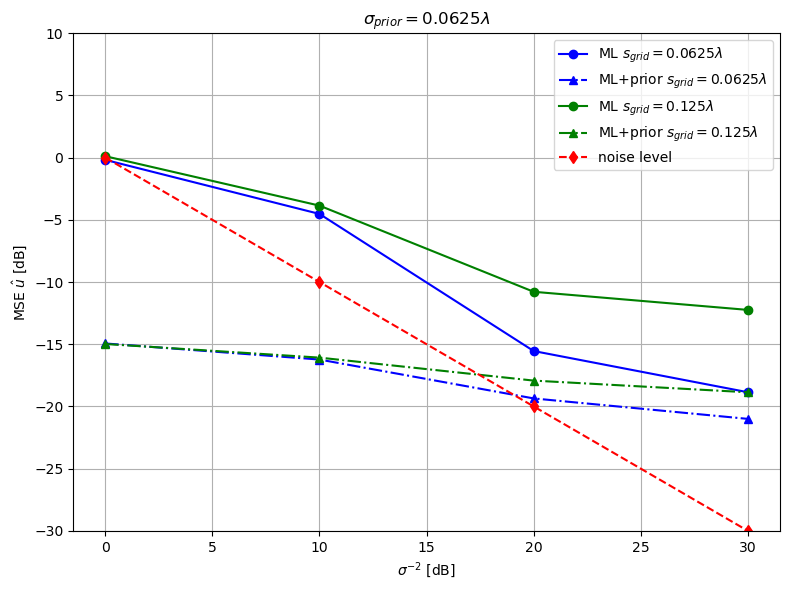

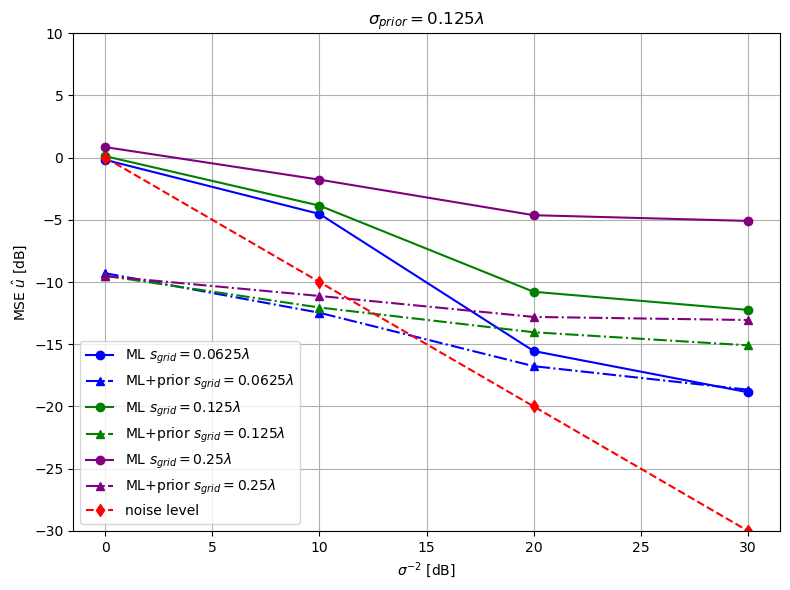

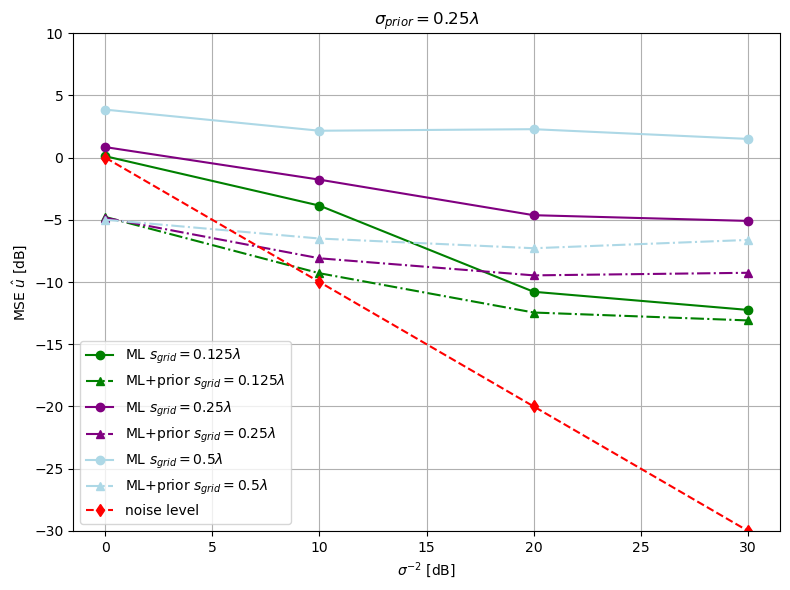

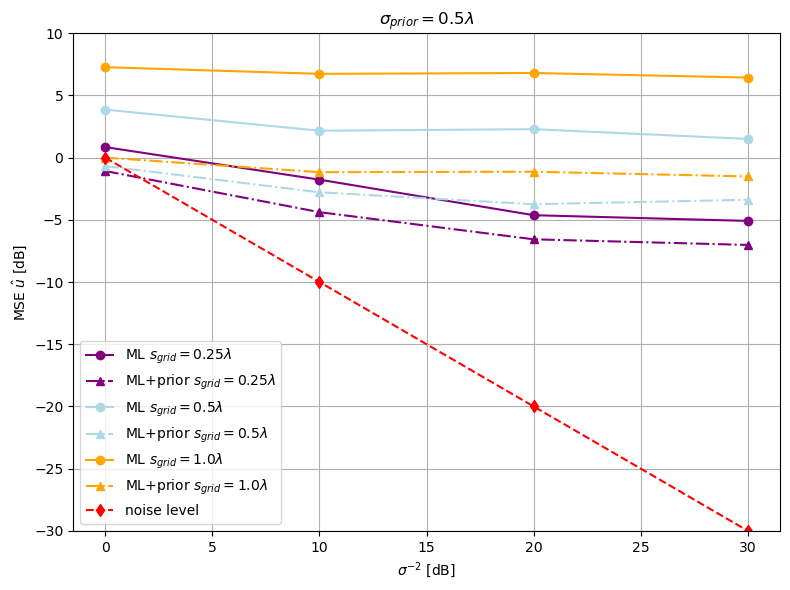

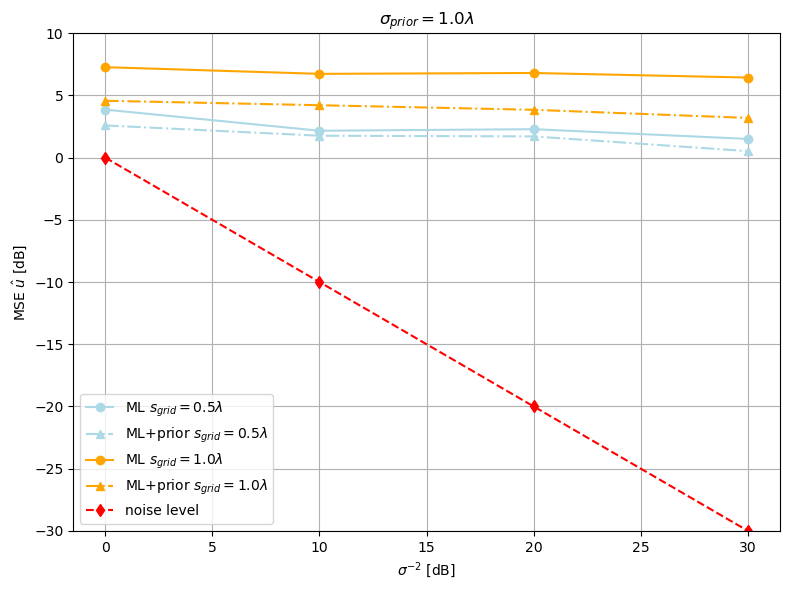

In [9]:
for i in range (len(prior_sigma)):
    plot_result_EXP3_1(noise_dB, ML_MSE_mean_dB[:,i,:],ML_MSE_mean_prior_dB[:,i,:],MSE_level_dB,ml_resol,lmb,prior_sigma[i,0])
    plt.title(r'$\sigma_{prior}=$'+f'{prior_sigma[i,0]/lmb}'+r'$\lambda$')
    plt.tight_layout()
    plt.savefig(filepath+f'/Exp3_MSE_prior_sigma_{prior_sigma[i,0]}.png')
    plt.savefig(filepath+f'/Exp3_MSE_prior_sigma_{prior_sigma[i,0]}.eps',format='eps') 

In [11]:
def plot_result_EXP3_2(noise_scale_dB,ML_MSE_mean_dB,ML_MSE_mean_prior_dB,MSE_floor_dB,prior_sigma,lmb,fixed_ml_resol):#fix ml_resol
    plt.figure(figsize=figsize)
    color=['b','g','purple','LightBLue','orange']
    plt.plot(noise_scale_dB,ML_MSE_mean_dB[:,0],'o-',label=r'ML ',c='black')
    for j in range(len(prior_sigma)):
        if(prior_sigma[j,0]<=2*fixed_ml_resol and prior_sigma[j,0]>=0.5*fixed_ml_resol):
            plt.plot(noise_scale_dB,ML_MSE_mean_prior_dB[:,j],'^-.',label=r'ML+prior $\sigma_{prior}=$'rf'{prior_sigma[j,0]/lmb}$\lambda$',c=color[j])
    plt.plot(noise_scale_dB,MSE_floor_dB,'d--',label=r'noise level',c='red')
    # plt.legend(bbox_to_anchor=(0.95, 1.2),ncol=3)
    plt.legend()

    plt.xlabel(r'$σ^{-2}$ [dB]')
    plt.ylabel(r'MSE $\hat{u}$ [dB]')
    plt.ylim([-30,10])
    plt.grid()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


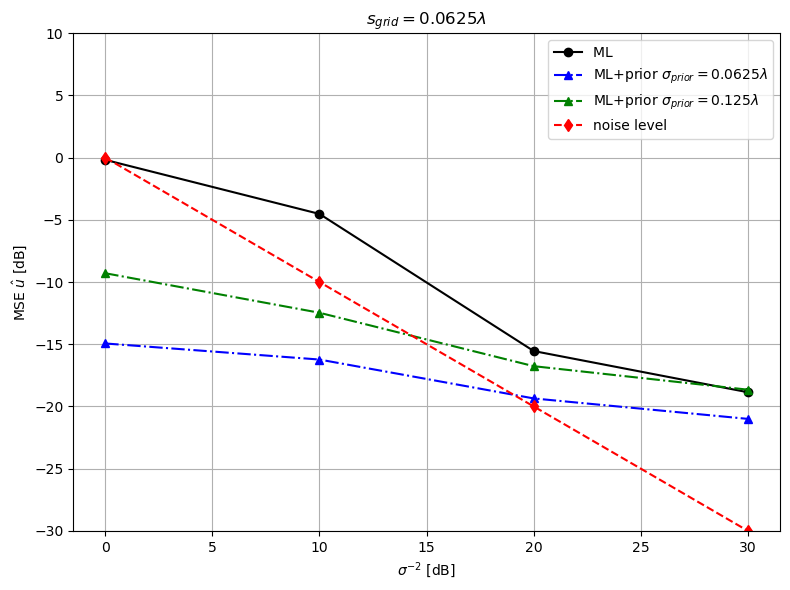

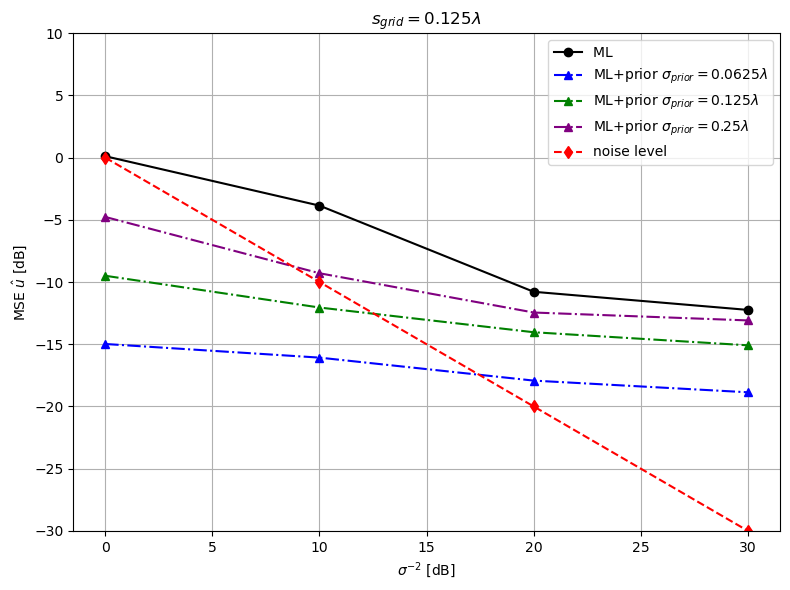

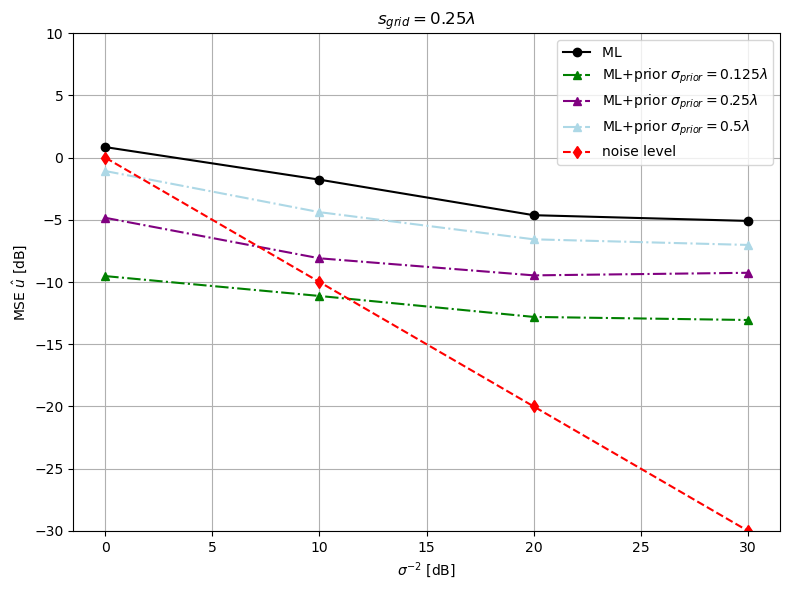

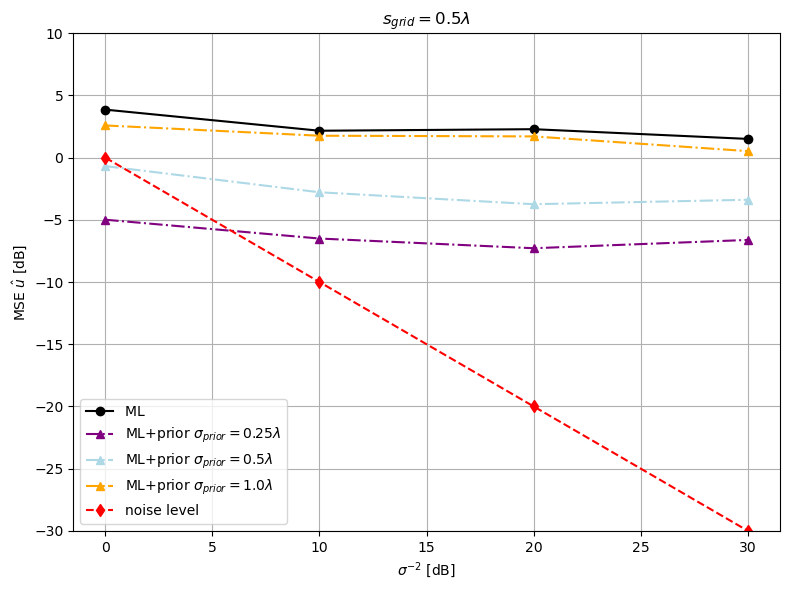

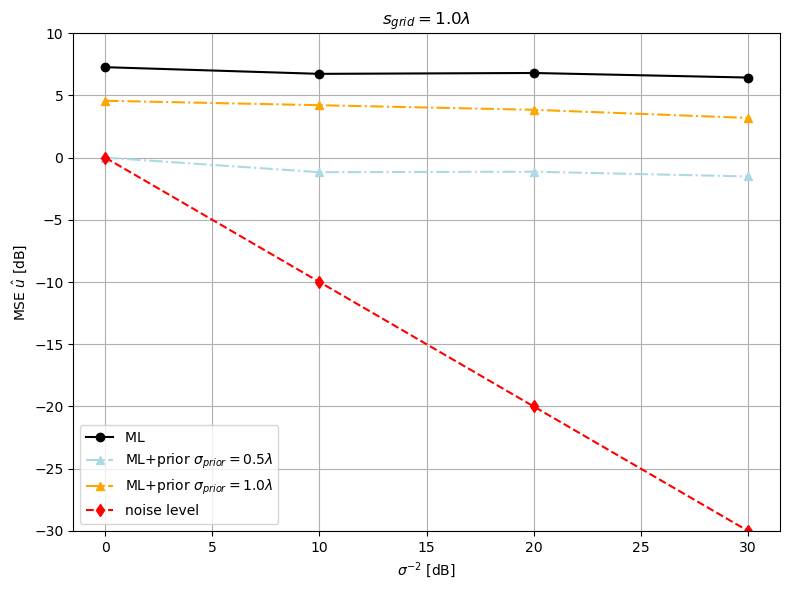

In [12]:
for i in range (len(ml_resol)):
    plot_result_EXP3_2(noise_dB, ML_MSE_mean_dB[:,:,i],ML_MSE_mean_prior_dB[:,:,i],MSE_level_dB,prior_sigma,lmb,ml_resol[i])
    plt.title(r'$s_{grid}=$'rf'{ml_resol[i]/lmb}$\lambda$')
    plt.tight_layout()
    plt.savefig(filepath+f'/Exp3_MSE_mlres_{ml_resol[i]}.png')
    plt.savefig(filepath+f'/Exp3_MSE_mlres_{ml_resol[i]}.eps',format='eps') 



## EXP3-2 special check . 
with a good resolution , the source of error due to SNR will be dominant （The slope becomes steeper).
But maybe the prior still has an effect (a poor prior with large variance). Check if this effect could be neglected.
Fix grid_size = 0.625lambda, priors (standard deviation) let us consider 0.0125, 0.25, 0.5 (you can maybe also consider 1).

In [6]:
#EXP3-speical 

from IPython.display import Audio
sound_file = 'cuckoo-clock-chimes-12-29462.mp3'

noise_dB=np.array([0,10,20,30])
position_noise_std=Noise_dB_to_std(noise_dB)

prior_sigma=np.empty([5,len(position_noise_std)])
for i in range(len(position_noise_std)):
    prior_sigma[:,i]=lmb*np.array([0.0625,0.125,0.25,0.5,1])

ml_resol=lmb*np.array([0.0625])

ML_MSE_mean=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_mean_prior=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std_prior=np.empty([len(position_noise_std),len(prior_sigma),len(ml_resol)])


for i in range(len(position_noise_std)):
    #generate phase measurements
    # true_targets,phase_observations=EXP3_phase_generate(N,lmb,d,targets,noise_std[i],phi_0=1) #add noise to phase 
    true_targets,phase_observations=EXP3_position_noise_to_phase_generate(N,lmb,d,targets,position_noise_std[i],phi_0=1) #add noise to position, then generate noise-free phase 
    
    for k in range(len(prior_sigma)):
        # synthetic priors
        prior_means=Synthetic_prior(targets,5,prior_sigma[k,i])
        for j in range(len(ml_resol)):
            print(f'prior_sigma = {prior_sigma[k,i]/lmb} wavelength,',f'position_noise_std:{position_noise_std[i]}, ML resolution:{ml_resol[j]/lmb}wavelength')
            if(k==0): #just need to execute once each prior_sigma
                ML_targets,num=experiment3(N,lmb,d,targets,phase_observations,ml_resol[j],prior_means,prior_sigma[k,i],False)
                ML_MSE_mean[i,0,j],ML_MSE_std[i,0,j]=evaluate(true_targets,ML_targets)
                for m in range(1,len(prior_sigma)):
                    ML_MSE_mean[i,m,j]=ML_MSE_mean[i,0,j]
                    ML_MSE_std[i,m,j]=ML_MSE_std[i,0,j]
                print(f'ML_mean_Squared_loss: {ML_MSE_mean[i,k,j]:.4},num:{num}')
            # ML_targets_prior, num_prior=experiment3(N,lmb,d,targets,phase_observations,ml_resol[j],prior_means,prior_sigma[k,i],True)
            # ML_MSE_mean_prior[i,k,j],ML_MSE_std_prior[i,k,j]=evaluate(true_targets,ML_targets_prior)
            # print(f'ML_mean_Squared_loss_prior: {ML_MSE_mean_prior[i,k,j]:.4},num:{num_prior}')


notify = Audio(sound_file, autoplay=True)
notify

prior_sigma = 0.0625 wavelength, position_noise_std:1.0, ML resolution:0.0625wavelength
ML processing time per iteration:3.0698782012000736s.
ML_mean_Squared_loss: 3.838e-06,num:52975
prior_sigma = 0.125 wavelength, position_noise_std:1.0, ML resolution:0.0625wavelength
prior_sigma = 0.25 wavelength, position_noise_std:1.0, ML resolution:0.0625wavelength
prior_sigma = 0.5 wavelength, position_noise_std:1.0, ML resolution:0.0625wavelength
prior_sigma = 1.0 wavelength, position_noise_std:1.0, ML resolution:0.0625wavelength
prior_sigma = 0.0625 wavelength, position_noise_std:0.31622776601683794, ML resolution:0.0625wavelength
ML processing time per iteration:1.6913906148002134s.
ML_mean_Squared_loss: 1.411e-06,num:52975
prior_sigma = 0.125 wavelength, position_noise_std:0.31622776601683794, ML resolution:0.0625wavelength
prior_sigma = 0.25 wavelength, position_noise_std:0.31622776601683794, ML resolution:0.0625wavelength
prior_sigma = 0.5 wavelength, position_noise_std:0.31622776601683794

In [12]:
position_noise_std=Noise_dB_to_std(noise_dB)
MSE_level_dB = np.negative(noise_dB)
print(MSE_level_dB)


ML_MSE_mean_scale=ML_MSE_mean/(lmb**2)  #scale according to wavelenth (not sure)
ML_MSE_mean_dB=todB(ML_MSE_mean_scale)
ML_MSE_std_scale=ML_MSE_std/(lmb**2)
ML_MSE_std_dB=todB(ML_MSE_mean_scale+ML_MSE_std_scale)-ML_MSE_mean_dB

# ML_MSE_mean_prior_scale=ML_MSE_mean_prior/(lmb**2)  #scale according to wavelenth (not sure)
# ML_MSE_mean_prior_dB=todB(ML_MSE_mean_prior_scale)
# ML_MSE_std_prior_scale=ML_MSE_std_prior/(lmb**2)
# ML_MSE_std_prior_dB=todB(ML_MSE_mean_prior_scale+ML_MSE_std_prior_scale)-ML_MSE_mean_prior_dB

[  0 -10 -20 -30]


In [15]:
with open(filepath+'/ML_MSE_mean_dB_special.txt', 'w') as outfile:
        for slice_2d in ML_MSE_mean_dB:
                np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol


with open(filepath+'/ML_MSE_std_dB_special.txt', 'w') as outfile:
        for slice_2d in ML_MSE_std_dB:
                np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol

# with open(filepath+'/ML_MSE_mean_prior_dB_special.txt', 'w') as outfile:
#         for slice_2d in ML_MSE_mean_prior_dB:
#                 np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol


# with open(filepath+'/ML_MSE_std_prior_dB_special.txt', 'w') as outfile:
#         for slice_2d in ML_MSE_std_prior_dB:
#                 np.savetxt(outfile, slice_2d,fmt = '%f', delimiter = ',')#行是prior_sigma,  列是ml_resol


In [16]:
noise_dB=np.array([0,10,20,30])
position_noise_std=Noise_dB_to_std(noise_dB)
MSE_level_dB = np.negative(noise_dB)
print(MSE_level_dB)

prior_sigma=np.empty([5,len(position_noise_std)])
for i in range(len(position_noise_std)):
    prior_sigma[:,i]=lmb*np.array([0.0625,0.125,0.25,0.5,1])

ml_resol=lmb*np.array([0.0625])


ML_MSE_mean_dB=np.loadtxt(filepath+'/ML_MSE_mean_dB_special.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std_dB=np.loadtxt(filepath+'/ML_MSE_std_dB_special.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_mean_prior_dB=np.loadtxt(filepath+'/ML_MSE_mean_prior_dB_special.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])
ML_MSE_std_prior_dB=np.loadtxt(filepath+'/ML_MSE_std_prior_dB_special.txt', delimiter = ',').reshape([len(position_noise_std),len(prior_sigma),len(ml_resol)])

[  0 -10 -20 -30]


In [17]:
def plot_result_EXP3_2_speicial(noise_scale_dB,ML_MSE_mean_dB,ML_MSE_mean_prior_dB,MSE_floor_dB,prior_sigma,lmb,fixed_ml_resol):#fix ml_resol
    plt.figure(figsize=figsize)
    color=['b','g','purple','LightBLue','orange']
    plt.plot(noise_scale_dB,ML_MSE_mean_dB[:,0],'o-',label=r'ML ',c='black')
    for j in range(len(prior_sigma)):
        if(prior_sigma[j,0]<=50*fixed_ml_resol and prior_sigma[j,0]>=0.5*fixed_ml_resol):
            plt.plot(noise_scale_dB,ML_MSE_mean_prior_dB[:,j],'^-.',label=r'ML+prior $\sigma_{prior}=$'rf'{prior_sigma[j,0]/lmb}$\lambda$',c=color[j])
    plt.plot(noise_scale_dB,MSE_floor_dB,'d--',label=r'noise level',c='red')
    # plt.legend(bbox_to_anchor=(0.95, 1.2),ncol=3)
    plt.legend()

    plt.xlabel(r'$σ^{-2}$ [dB]')
    plt.ylabel(r'MSE $\hat{u}$ [dB]')
    plt.ylim([-30,10])
    plt.grid()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


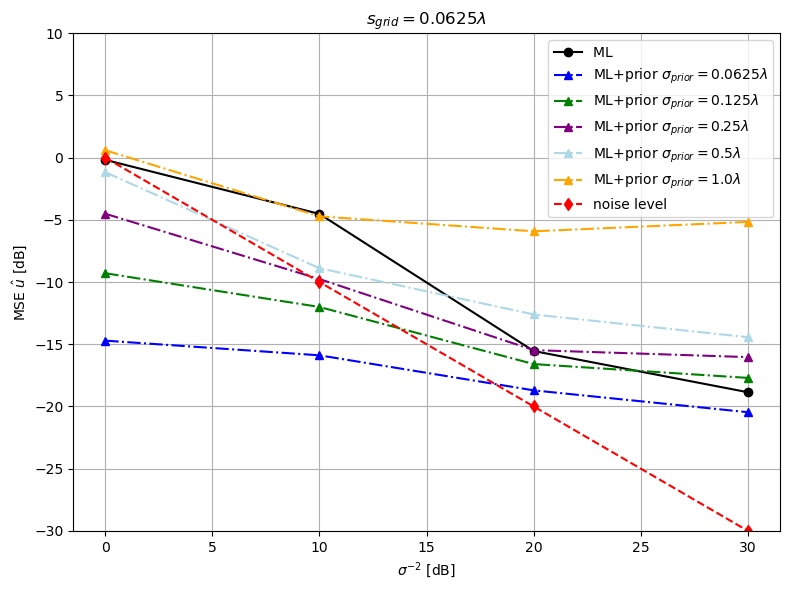

In [18]:
for i in range (len(ml_resol)):
    plot_result_EXP3_2_speicial(noise_dB, ML_MSE_mean_dB[:,:,i],ML_MSE_mean_prior_dB[:,:,i],MSE_level_dB,prior_sigma,lmb,ml_resol[i])
    plt.title(r'$s_{grid}=$'rf'{ml_resol[i]/lmb}$\lambda$')
    plt.tight_layout()
    plt.savefig(filepath+f'/Exp3_MSE_mlres_{ml_resol[i]}_speicial.png')
    plt.savefig(filepath+f'/Exp3_MSE_mlres_{ml_resol[i]}_speicial.eps',format='eps') 
